In [128]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

from matplotlib import pyplot as plt
%matplotlib inline

class Helper():

    @staticmethod
    def mse(y):
        return mean_squared_error(y, [np.mean(y)] * len(y))

    @staticmethod
    def mae(y):
        return mean_absolute_error(y, [np.mean(y)] * len(y))
    

class Node():

    def __init__(self, data, 
                 parent=None, 
                 criterion='mse',
                 leaf_poly='linear'):
        
        self.data = data
        
        if leaf_poly == 'poly':
            self.poly_model = make_pipeline(PolynomialFeatures(3), Ridge())
            self.poly_model.fit(data[:, :-1], data[:, -1])
        elif leaf_poly == 'linear':
            self.value = np.mean(data[:, -1])
        else:
            pass
        
        if criterion == 'mse':
            self.error = Helper.mse(data[:, -1])
        elif criterion == 'mae':
            self.error = Helper.mae(data[:, -1])
        else:
            pass

        self.split_feat_idx = None
        self.split_feat_value = None

        self.left = None
        self.right = None
        self.parent = parent


class Tree():

    def __init__(self, data, 
                 criterion='mse', 
                 error_thres=0.1, 
                 split_fold_n=10, 
                 weighted=False, 
                 leaf_poly='linear'):
        
        self.root = Node(data, 
                         criterion=criterion, 
                         leaf_poly=leaf_poly)
        self.current_node = self.root
        self.criterion = criterion
        self.error_thres = error_thres
        self.split_fold_n = split_fold_n
        self.weighted = weighted
        self.leaf_poly = leaf_poly


    def split(self):
        current_data = self.current_node.data
        current_error = self.current_node.error

        current_error_gain = 0
        current_split_value = 0
        current_split_pos = [0, 0]

        # loop each column of features to search for split position
        for i in range(current_data.shape[1] - 1):

            current_data = current_data[current_data[:, i].argsort()]
            current_feature = current_data[:, i]
            current_y = current_data[:, -1]

            self.split_fold_n = len(current_feature)  # maybe too slow
            interval = int(len(current_feature) / self.split_fold_n)

            for j in range(1, self.split_fold_n):
                split_pos = j * interval

                if self.criterion == 'mse':
                    split_error0, split_error1 = Helper.mse(current_y[: split_pos]), Helper.mse(current_y[split_pos:])
                elif self.criterion == 'mae':
                    split_error0, split_error1 = Helper.mae(current_y[: split_pos]), Helper.mae(current_y[split_pos:])
                else:
                    pass
                
                if self.weighted:
                    error_gain = current_error - split_error0 * split_pos / len(current_y) - split_error1 * (len(current_y) - split_pos) / len(current_y)
                else:
                    error_gain = current_error - split_error0 - split_error1
                
                if error_gain > current_error_gain:
                    current_split_pos = [i, split_pos]
                    current_split_value = current_feature[split_pos]
                    current_error_gain = error_gain

        # cannot find a split position by error gain
        if current_error_gain == 0:
            return False

        # split
        self.current_node.split_feat_idx = current_split_pos[0]
        self.current_node.split_feat_value = current_split_value

        current_data = current_data[current_data[:, current_split_pos[0]].argsort()]
        split_data0, split_data1 = current_data[: current_split_pos[1]], current_data[current_split_pos[1]:]

        node0 = Node(data=split_data0, 
                     parent=self.current_node, 
                     criterion=self.criterion, 
                     leaf_poly=self.leaf_poly)
        node1 = Node(data=split_data1, 
                     parent=self.current_node, 
                     criterion=self.criterion,
                     leaf_poly=self.leaf_poly)

        self.current_node.left = node0
        self.current_node.right = node1

        return True

    def check_split(self):
        if len(self.current_node.data) == 1:
            return False

        if self.current_node.error < self.error_thres:
            return False

        current_node_y = self.current_node.data[:, -1]

        if len(current_node_y[current_node_y == current_node_y[0]]) == len(current_node_y):
            return False

        return True

    def fit(self):

        if not self.check_split():
            return

        if not self.split():
            return

        for self.current_node in [self.current_node.left, self.current_node.right]:
            self.fit()

        self.current_node = self.root

    def predict_(self, x):
        # leaf node
        if self.current_node.split_feat_idx is None:
            if self.leaf_poly == 'linear':
                return self.current_node.value
            elif self.leaf_poly == 'poly':
                return self.current_node.poly_model.predict(x.reshape(1, -1))
            else:
                pass

        feat_idx, feat_value = self.current_node.split_feat_idx, self.current_node.split_feat_value

        self.current_node = self.current_node.left if x[feat_idx] < feat_value else self.current_node.right

        return self.predict_(x)
    
    def predict(self, X):
        
        preds = []
        for i, x in enumerate(X):
            self.current_node = self.root
            pred = self.predict_(x)
            preds.append(pred)
            
        return preds
        
    def prune(self):
        pass

### Toppan test

In [129]:
import os
import pandas as pd

in_dir = 'D:\\Toppan\\2017-11-20 全データ\\処理済(総量)\\vectorized_keikaku_shibata'
files = [f for f in os.listdir(in_dir)]

#train_month_file, test_month_file = '201801010800.xlsx', '201802010800.xlsx'
train_month_file, test_month_file = '201701010800.xlsx', '201802010800.xlsx'

In [139]:
def pred_energy(energy, train_month_file, test_month_file):

    train_df = pd.read_excel(os.path.join(in_dir, train_month_file), sheet_name=energy)
    test_df = pd.read_excel(os.path.join(in_dir, test_month_file), sheet_name=energy)

    dtr = Tree(train_df.values, weighted=True, error_thres=0.0001)
    dtr.fit()

    pred_dtr = dtr.predict(test_df.values[:, :-1])

    plt.figure(figsize=(20, 8))
    
    plt.title(energy)
    plt.plot(pred_dtr, label='pred')
    plt.plot(test_df.values[:, -1], label='true')
    #plt.plot(pred_dtr - test_df.values[:, -1], label='diff')
    
    print('mse: ', mean_squared_error(pred_dtr, test_df.values[:, -1]))
    
    plt.legend()

mse:  0.19297864676616916


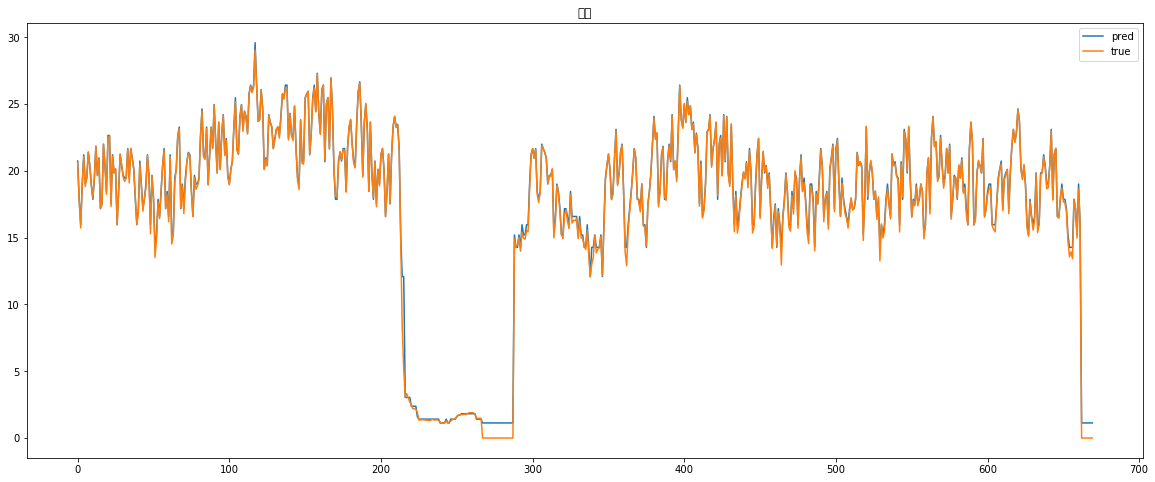

In [140]:
pred_energy('蒸気', train_month_file, test_month_file)

mse:  0.011940298507462687


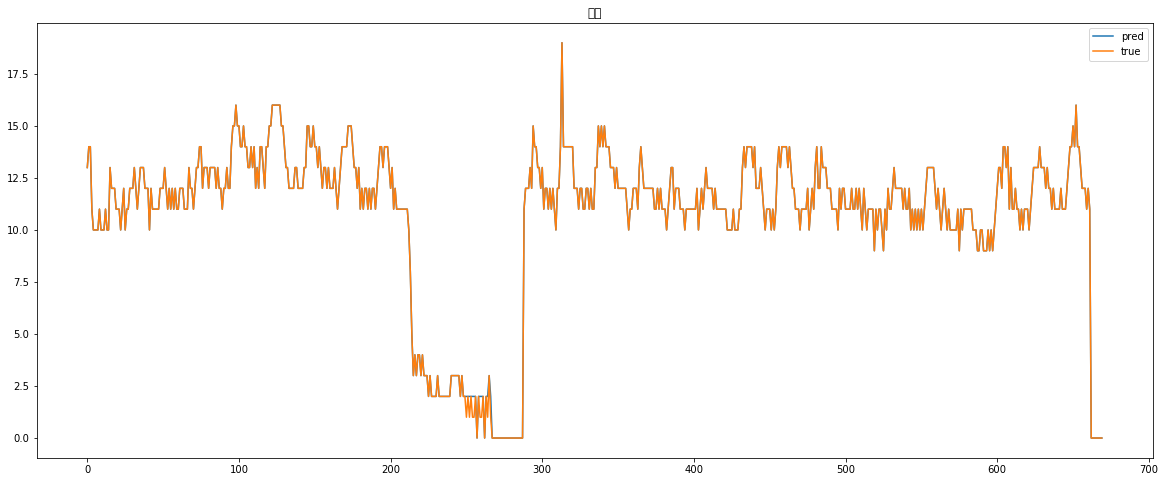

In [141]:
pred_energy('冷水', train_month_file, test_month_file)

mse:  13612.926865671641


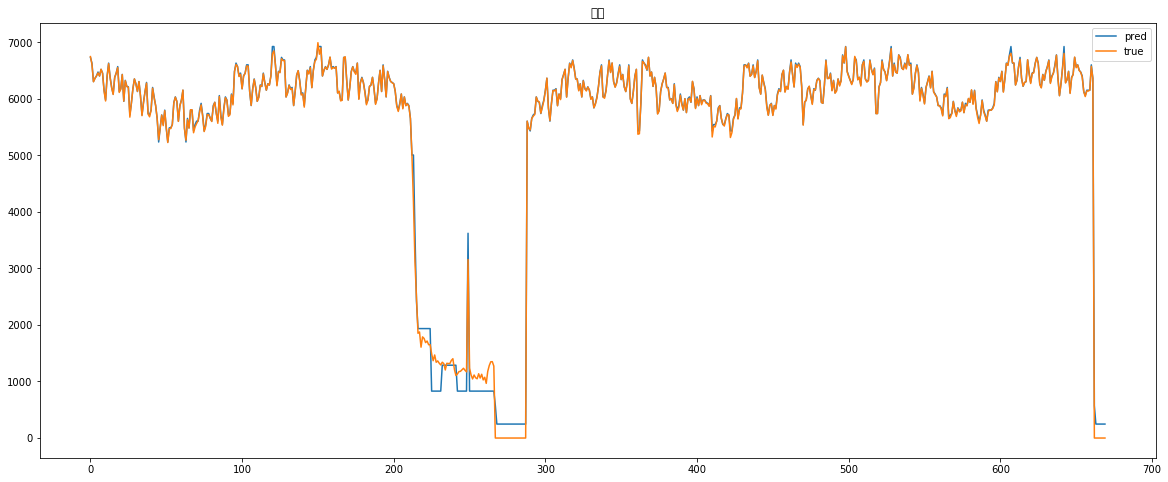

In [142]:
pred_energy('電力', train_month_file, test_month_file)